# Algorithmic Trading Bot using Moving Average Crossover Strategy
This notebook outlines the creation and backtesting of a simple trading bot based on the Moving Average Crossover strategy using the `backtrader` library.


In [59]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached bokeh-3.2.2-py3-none-any.whl (7.8 MB)
ERROR: Could not find a version that satisfies the requirement btplotting==0.2.1 (from versions: none)
ERROR: No matching distribution found for btplotting==0.2.1
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [64]:
%pip install git+https://github.com/happydasch/btplotting

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/happydasch/btplotting to /private/var/folders/0h/s0zvhcnd6573h3xrtcsxc8140000gn/T/pip-req-build-3xgvi8mp
  Running command git clone -q https://github.com/happydasch/btplotting /private/var/folders/0h/s0zvhcnd6573h3xrtcsxc8140000gn/T/pip-req-build-3xgvi8mp
  Resolved https://github.com/happydasch/btplotting to commit 2e50b15bde3dc9081a17c2f2d85b5ee0659c9a77
  Using cached bokeh-3.2.2-py3-none-any.whl (7.8 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached PyYAML-6.0.1-cp39-cp39-macosx_10_9_x86_64.whl (197 kB)
  Using cached xyzservices-2023.7.0-py3-none-any.whl (56 kB)
  Using cached MarkupSafe-2.1.3-cp39-cp39-macosx_10_9_x86_64.whl (13 kB)
  Created wheel for btplotting: filename=btplotting-0.2.1-py3-none-any.whl size=75289 sha256=fab95a9690f473863bc3ad033795a36b5d8750313e72fe12e79c0850556186d3
  Stored in directory: /private/var/folders/0h/s0zvhcnd6573h3xrt

In [72]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from btplotting import BacktraderPlottingLive


Strategies

In [49]:
class MovingAverageCrossoverStrategy(bt.Strategy):
    params = (
        ("fast_ma", 50),
        ("slow_ma", 200),
        ("order_percentage", 0.95),
        ("ticker", "AAPL")
    )

    def __init__(self):
        self.fast_ma = bt.indicators.SMA(self.data.close, period=self.params.fast_ma)
        self.slow_ma = bt.indicators.SMA(self.data.close, period=self.params.slow_ma)
        self.crossover = bt.indicators.CrossOver(self.fast_ma, self.slow_ma)

    def next(self):
        if self.position.size == 0:
            if self.crossover > 0:
                amount_to_invest = (self.params.order_percentage * self.broker.cash)
                self.size = amount_to_invest / self.data.close

                self.buy(size=self.size)
        elif self.crossover < 0:
            self.sell(size=self.position.size)


In [50]:
class MeanReversionStrategy(bt.Strategy):
    params = (
        ('period', 20),           # Period for the moving average
        ('devfactor', 2.0),       # Bollinger band distance from the moving average
        ('order_percentage', 0.95),  # Order size as a percentage of available cash
        ('ticker', 'AAPL')
    )

    def __init__(self):
        self.ma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.period)
        self.bollinger = bt.indicators.BollingerBands(self.data.close, period=self.params.period, devfactor=self.params.devfactor)

    def next(self):
        if self.position.size == 0:
            if self.data.close < self.bollinger.lines.bot:  # if the close price is below the bottom Bollinger band
                amount_to_invest = (self.params.order_percentage * self.broker.cash)
                self.size = amount_to_invest / self.data.close
                self.buy(size=self.size)
                
            if self.data.close > self.bollinger.lines.top:  # if the close price is above the top Bollinger band
                amount_to_invest = (self.params.order_percentage * self.broker.cash)
                self.size = amount_to_invest / self.data.close
                self.sell(size=self.size)

        elif self.position.size > 0 and self.data.close > self.ma:  # Close the long position if close price is above the moving average
            self.close()

        elif self.position.size < 0 and self.data.close < self.ma:  # Close the short position if close price is below the moving average
            self.close()


In [51]:
class PairsTradingStrategy(bt.Strategy):
    params = (
        ('window_size', 128),
        ('zscore_threshold', 2.0), # Z-score threshold for buying/selling the spread
    )
    
    def __init__(self):
        # Retrieve the data series for the two stocks
        self.stock1 = self.datas[0]
        self.stock2 = self.datas[1]
        # Calculate the spread and mean/stddev of the spread
        self.spread = self.stock1.close - self.stock2.close
        self.zscore = (self.spread - bt.indicators.SimpleMovingAverage(self.spread, period=self.params.window_size)) / bt.indicators.StdDev(self.spread, period=self.params.window_size)

    def next(self):
        # Check conditions for going long on the spread (buy stock1, sell stock2)
        if self.zscore < -self.params.zscore_threshold:
            self.buy(data=self.stock1)
            self.sell(data=self.stock2)
        
        # Check conditions for going short on the spread (sell stock1, buy stock2)
        elif self.zscore > self.params.zscore_threshold:
            self.sell(data=self.stock1)
            self.buy(data=self.stock2)
        
        # Check conditions for closing long position on the spread
        elif self.zscore >= 0 and self.getposition(self.stock1).size > 0:
            self.close(data=self.stock1)
            self.close(data=self.stock2)

        # Check conditions for closing short position on the spread
        elif self.zscore <= 0 and self.getposition(self.stock1).size < 0:
            self.close(data=self.stock1)
            self.close(data=self.stock2)


Running Moving Average Crossover Strategy

In [52]:
cerebro = bt.Cerebro()
cerebro.addstrategy(MovingAverageCrossoverStrategy)

# Load data
data_df = yf.download("AAPL", start="2018-01-01", end="2023-01-01")

# Convert the data to backtrader format
data_bt = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data_bt)

cerebro.broker.set_cash(100000)  # Start with $100,000
cerebro.broker.setcommission(commission=0.001)  # 0.1% commission on trades

start_portfolio_value = cerebro.broker.getvalue()

cerebro.run()

end_portfolio_value = cerebro.broker.getvalue()
print(f"Starting Portfolio Value: {start_portfolio_value}")
print(f"Ending Portfolio Value: {end_portfolio_value}")


[*********************100%%**********************]  1 of 1 completed
Starting Portfolio Value: 100000
Ending Portfolio Value: 265961.0476990396


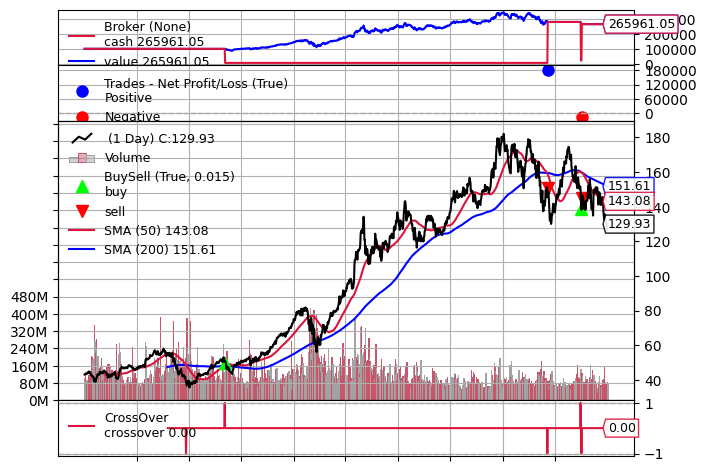

[[<Figure size 640x480 with 5 Axes>]]

In [53]:
%matplotlib inline
cerebro.plot(iplot=False)  # Setting iplot=False ensures it uses the standard matplotlib library and not an interactive plot.


Trying mean reversion strategy

In [54]:
cerebro = bt.Cerebro()
cerebro.addstrategy(MeanReversionStrategy)
tickers = ["AAPL"]
# Load data
data_df = yf.download("AAPL", start="2018-01-01", end="2023-01-01")

# Convert the data to backtrader format
data_bt = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data_bt)

cerebro.broker.set_cash(100000)  # Start with $100,000
cerebro.broker.setcommission(commission=0.001)  # 0.1% commission on trades

start_portfolio_value = cerebro.broker.getvalue()

cerebro.run()

end_portfolio_value = cerebro.broker.getvalue()
print(f"Starting Portfolio Value: {start_portfolio_value}")
print(f"Ending Portfolio Value: {end_portfolio_value}")


[*********************100%%**********************]  1 of 1 completed
Starting Portfolio Value: 100000
Ending Portfolio Value: 31567.023372165186


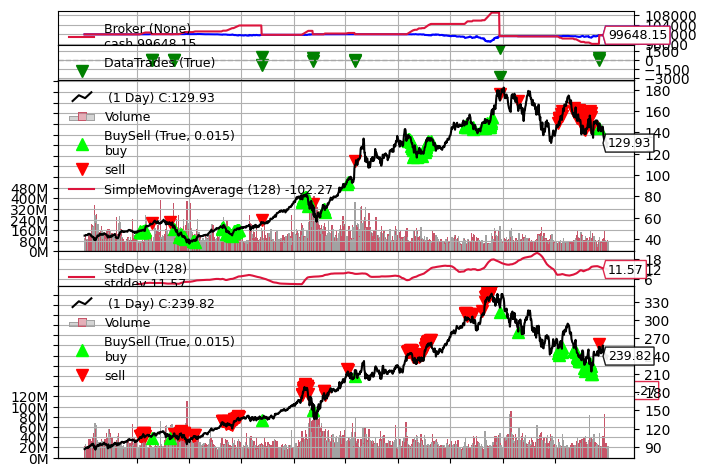

[[<Figure size 640x480 with 7 Axes>]]

In [73]:
%matplotlib inline
cerebro.plot(iplot=False)  # Setting iplot=False ensures it uses the standard matplotlib library and not an interactive plot.

Running Pairs Strategy

In [69]:
cerebro = bt.Cerebro()

cerebro.addstrategy(PairsTradingStrategy)

data_df_1 = yf.download("AAPL", start="2018-01-01", end="2023-01-01")
data_df_2 = yf.download("MSFT", start="2018-01-01", end="2023-01-01")

# Convert the data to backtrader format
data_bt_1 = bt.feeds.PandasData(dataname=data_df_1)
data_bt_2 = bt.feeds.PandasData(dataname=data_df_2)
cerebro.adddata(data_bt_1)
cerebro.adddata(data_bt_2)
cerebro.addanalyzer(BacktraderPlottingLive)
cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.001)
start_portfolio_value = cerebro.broker.getvalue()
cerebro.run()
end_portfolio_value = cerebro.broker.getvalue()
print(f"Starting Portfolio Value: {start_portfolio_value}")
print(f"Ending Portfolio Value: {end_portfolio_value}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Starting Portfolio Value: 100000
Ending Portfolio Value: 99648.15189418787


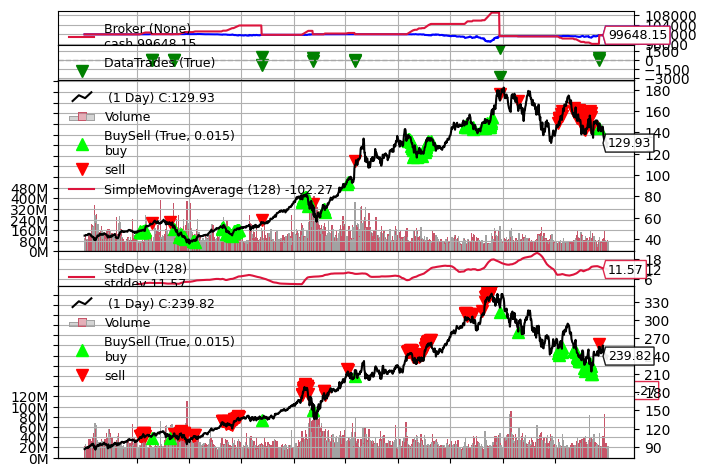

[[<Figure size 640x480 with 7 Axes>]]

In [75]:
%matplotlib inline

cerebro.plot(iplot=False)